# Tabular Q-Learning with bins with CartPole env

This example uses tabular Q learning but discretizing a continous state-space with bins applied to the CartPole environment

In [2]:
import gym
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image

## Auxiliary functions And Objects

Mainly the functions related to the discretization of the continous environment

In [3]:
def build_state_from_list(features):
    """Converts a list of integers into an int by contatinating them(not sum)
       example: [1,8,6,5,7] -> 18657 
    """
    return int("".join([str(num) for num in features]))

build_state_from_list([1,8,6,5,7])

18657

In [4]:
def to_bin(value,bins):
    """Given a value and a list of values representing bin limits
        it returns the number of bin it belongs to.
        example: the value=10 if bins are [1,2] ,[2,3],[3,6],[6,8],[8,11] belongs to bin 5 [8,11]
    """
    return np.digitize(x=[value],bins=bins)[0] 

to_bin(10,bins=[1,2,3,6,8,11])

5

In [5]:
class StateTransformer:
    """Similar to sklearn-s featureTransformer takes a state 
    and transform to the discretized version"""
    def __init__(self):
        # size = 9 to get 10 bins
        self.cart_position_bins = np.linspace(-2.4,2.4,9)
        self.cart_velocity_bins = np.linspace(-2,2,9)
        self.pole_angle_bins = np.linspace(-0.4,0.4,9)
        self.pole_velocity_bins = np.linspace(-3.5,3.5,9)

    def transform(self, state):
        cart_position, cart_velocity, pole_angle, pole_velocity = state
        return build_state_from_list([
            to_bin(cart_position, self.cart_position_bins),
            to_bin(cart_velocity,self.cart_velocity_bins),
            to_bin(pole_angle, self.pole_angle_bins),
            to_bin(pole_velocity,self.pole_velocity_bins)
        ])

In [6]:
def plot_running_average(total_rewards):
    """Plots the running average of the returns
       using running mean to smooth the noisy rewards curve
    """
    N = len(total_rewards)

    running_means =  np.convolve(total_rewards, np.ones((N,))/N)[(N-1):]
    plt.plot(running_means)
    plt.show()


## Q Learning

In [7]:
class QModel:
    """This encapsulates all operations for the Q-Learning algorithm"""
    def __init__(self, environment: gym.Env, state_transformer: StateTransformer,lr=10e-3):
        self.environment = environment
        self.state_transformer = state_transformer
        self.lr = lr

        number_of_states = 10**environment.observation_space.shape[0] #since there are 10 bins and 4 actions states are 10 ^ 4
        number_of_actions = environment.action_space.n

        self.Q_table = np.random.uniform(low = -1, high = -1,size=(number_of_states,number_of_actions))

    def predict_Q(self,state):
        """Gets the q values of a state after discritizing it"""
        disc_state = self.state_transformer.transform(state)
        return self.Q_table[disc_state]
    
    def update_Q(self,state, action, returnG):
        """Perform a Q learning update to the Q table"""
        disc_state = self.state_transformer.transform(state)
        self.Q_table[disc_state,action] = self.Q_table[disc_state,action] + self.lr*(returnG-self.Q_table[disc_state,action])

    def epsilon_greedy_sample_action(self, state, epsilon):
        if np.random.random() < epsilon:  # explore
            return self.environment.action_space.sample()
        else: #exploit
            state_q = self.predict_Q(state)
            return np.argmax(state_q)

In [8]:
def run_episode(environment: gym.Env, q_model: QModel, epsilon:float, gamma:float):
    """Runs an episode and returns a list of states, rewards and the total reward
      epsilon = exploration probability
      gamma = discount factor for the returns
    """
    state,_ = environment.reset()
    done = False
    total_reward = 0 
    iterations = 0

    while not done and iterations < 10000:
        action = q_model.epsilon_greedy_sample_action(state,epsilon)
        new_state, reward, done, trunc, info = environment.step(action)
        total_reward += reward

        # newer versions of gym will preliminary terminate the episode in 200 iterations
        # if it is done in less than that that means the poll fell so it is a big negative reward
        if done and iterations < 199:
            reward = -300

        G_return = reward + gamma*np.max(q_model.predict_Q(new_state))
        q_model.update_Q(state,action,G_return)

        state = new_state
        iterations += 1

    return total_reward

### Check an untrained agent

In [9]:
environment = gym.make("CartPole-v0",render_mode="rgb_array")
state_transformer = StateTransformer()
q_model = QModel(environment,state_transformer)

state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 1.0  # starts fully exploring
renders = [] # will store the environment frames to create a gif later

while not done:
    action = q_model.epsilon_greedy_sample_action(state,epsilon)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

/home/luis/anaconda3/envs/python311_torch113_tf212/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Total reward 22.0 in 22 iterations


In [10]:
imgs = [Image.fromarray(img) for img in renders]
imgs[0].save("../animations/QLearningBinsCartPoleUntrained.gif",save_all=True, append_images=imgs[1:],loop=0)

<img src="../animations/QLearningBinsCartPoleUntrained.gif" width="750" align="center" loop=False>

### Training

Episode 0, epsilon:1.0, total_reward 12.0
Episode 1000, epsilon:0.9231133922615287, total_reward 12.0
Episode 2000, epsilon:0.8521383349725863, total_reward 13.0
Episode 3000, epsilon:0.7866203090726344, total_reward 36.0
Episode 4000, epsilon:0.7261397419298532, total_reward 15.0
Episode 5000, epsilon:0.6703093204287764, total_reward 40.0
Episode 6000, epsilon:0.6187715106455282, total_reward 63.0
Episode 7000, epsilon:0.5711962682267844, total_reward 30.0
Episode 8000, epsilon:0.5272789248099539, total_reward 69.0
Episode 9000, epsilon:0.4867382369493269, total_reward 45.0
Episode 10000, epsilon:0.4493145850536891, total_reward 73.0
Episode 11000, epsilon:0.414768310801491, total_reward 146.0
Episode 12000, epsilon:0.38287818238654725, total_reward 119.0
Episode 13000, epsilon:0.35343997776577235, total_reward 154.0
Episode 14000, epsilon:0.32626517683620004, total_reward 159.0
Episode 15000, epsilon:0.3011797541660731, total_reward 168.0
Episode 16000, epsilon:0.2780230645487366, to

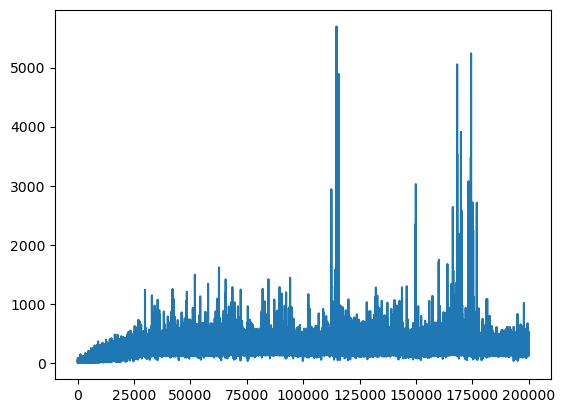

In [11]:
EPISODES = 200000
PRINT_EVERY = 1000

environment = gym.make("CartPole-v0",render_mode="rgb_array")
state_transformer = StateTransformer()
q_model = QModel(environment,state_transformer)
gamma  = 0.9 # disccount factor
epsilon_decay = 0.99992
epsilon = 1.0 # start fully exploring

total_rewards = np.empty(EPISODES)

for episode_num in range(EPISODES):
    total_reward = run_episode(environment,q_model,epsilon,gamma)
    total_rewards[episode_num] = total_reward
    

    if episode_num % PRINT_EVERY == 0:
        print(f"Episode {episode_num}, epsilon:{epsilon}, total_reward {total_reward}")
    epsilon = epsilon*epsilon_decay if epsilon > 0.07 else 0.07
print(f"Mean reward for last 100 episodes:{total_rewards[-100:].mean()}")

plt.plot(total_rewards)
plt.show()

Smooth the curve with running mean

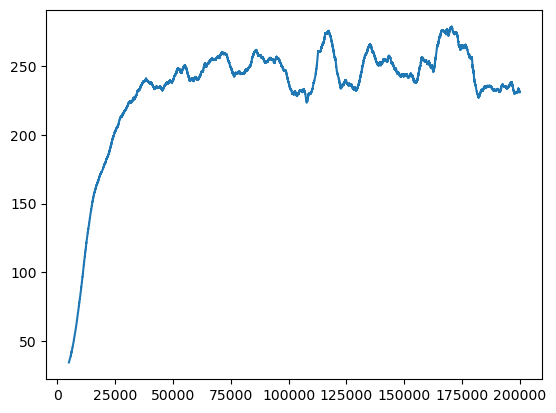

In [19]:
df = pd.DataFrame(data=total_rewards,columns=["reward"])
df["running_mean"] = df["reward"].rolling(window=5000).mean()
plt.plot(df.running_mean)
plt.show()

### Run an episode rendering the process with a trained agent

In [25]:
state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 0.0 #no exploration
renders = [] # will store the environment frames to create a gif later

while not done:
    action = q_model.epsilon_greedy_sample_action(state,epsilon)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

Total reward 447.0 in 447 iterations


In [26]:
imgs = [Image.fromarray(img) for img in renders]
imgs[0].save("../animations/QLearningBinsCartPole.gif",save_all=True, append_images=imgs[1:],loop=0)

<img src="../animations/introCartPole0.gif" width="750" align="center" loop=False>